# **Sampling Raster Data**

# **Overview**

Many scientific and environmental datasets come as gridded rasters. If you want to know the value of a variable at a single or multiple locations, you can use sampling techniques to extract the values. XArray has powerful indexing methods that allow us to extract values at multiple coordinates easily. 

In this tutorial, we will take a raster file of temperature anomanies and a CSV file with locations of all urban areas in the US. We will use Pandas and Xarray to find the temperature anomaly at all the urban areas and find the top 10 areas experiencing highest anomaly. We will also use GeoPandas to save the results as a vector layer.

Input Layers:

* `t.anom.202207.tif`: Raster grid of temprature anomaly for the month of July 2022 in the US.
*  `2021_Gaz_ua_national.zip`: A CSV file with point locations representing urban areas in the US.

Output Layers:

*   `tanomaly.gpkg` : A GeoPackage containing a vector layer of point locations with anomaly values sampled from the raster.


Data Credit:

*   [US July 2021 Temperature Anomaly](https://www.cpc.ncep.noaa.gov/products/GIS/GIS_DATA/). NOAA Climate Prediction Center. Retrieved 2022-09

*   [US Gazetteer files: 2021](https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2021.html) United States Census Bureau. Retrieved 2022-09.


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [133]:
%%capture
if 'google.colab' in str(get_ipython()):
    !apt install libspatialindex-dev
    !pip install fiona shapely pyproj rtree
    !pip install geopandas
    !pip install rioxarray

In [134]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rxr

In [135]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [136]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

raster_file = 't.anom.202207.tif'
csv_file = '2021_Gaz_ua_national.zip'

files = [
    'https://ftp.cpc.ncep.noaa.gov/GIS/USDM_Products/temp/anom/monthly/' + raster_file,
    'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2021_Gazetteer/' + csv_file,
]

for file in files:
  download(file)

# Data Pre-Processing

First we read the raster file using `rioxarray`

In [137]:
raster_filepath = os.path.join(data_folder, raster_file)
raster = rxr.open_rasterio(raster_filepath, mask_and_scale=True)
raster

<xarray.DataArray (band: 1, y: 32, x: 64)>
array([[[-9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08],
        [-9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08],
        ...,
        [-9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08],
        [-9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -130.0 -129.0 -128.0 -127.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 52.0 51.0 50.0 49.0 48.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 0

You will notice that the raster has many pixels with value -9.99e+08. These are NoData values but they are not encoded as such. We will mask these values to get only the valid pixels.

In [138]:
nodata = -999000000
raster_masked = raster.where(raster != nodata)
raster_masked

<xarray.DataArray (band: 1, y: 32, x: 64)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -130.0 -129.0 -128.0 -127.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 52.0 51.0 50.0 49.0 48.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 0

The raster has only 1 band containing temperature anomaly values, so we select it.

In [139]:
tanomaly = raster_masked.sel(band=1)
tanomaly

<xarray.DataArray (y: 32, x: 64)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -130.0 -129.0 -128.0 -127.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 52.0 51.0 50.0 49.0 48.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 0

Let's plot the data. It shows high temperature anomaly in the north-west US due to a [record-breaking heatwave](https://phys.org/news/2022-05-hidden-backstory-deadly-pacific-northwest.html).

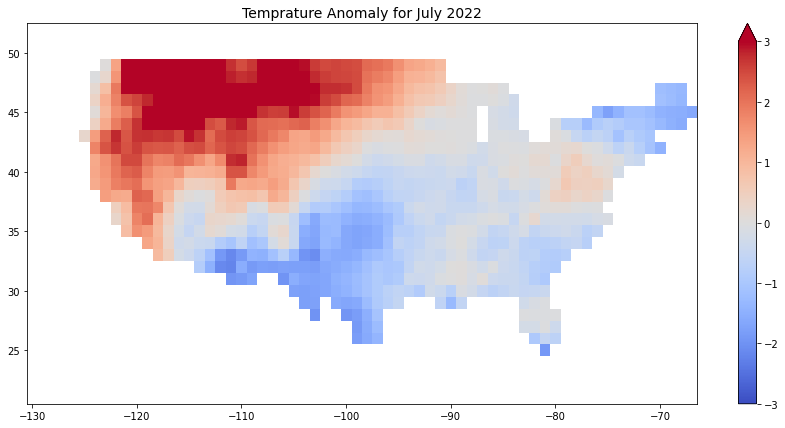

In [140]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

tanomaly.plot.imshow(ax=ax,
    vmin=-3, vmax=3, add_labels=False, cmap='coolwarm')

ax.set_title('Temprature Anomaly for July 2022', fontsize = 14)

plt.show()

Next, we read the Zipped CSV file containing the urban areas. This is a plain-text file with tab separated values. The column names also contain trailing whitespaces, so we remove them as well.

In [ ]:
csv_filepath = os.path.join(data_folder, csv_file)
df  = pd.read_csv(csv_filepath, delimiter = '\t', compression='zip')
df.columns = df.columns.str.replace(' ', '')
df

Since we have the coordinates of each urban center in the *INTPTLAT* and *INTPTLONG* columns, we can convert this dataframe to a GeoDataFrame.

In [142]:
geometry = gpd.points_from_xy(df.INTPTLONG, df.INTPTLAT)
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)
gdf

,GEOID,NAME,UATYPE,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,geometry
0,37,"Abbeville, LA Urban Cluster",C,29189598,298416,11.270,0.115,29.967156,-92.095966,POINT (-92.09597 29.96716)
1,64,"Abbeville, SC Urban Cluster",C,11271136,19786,4.352,0.008,34.179273,-82.379776,POINT (-82.37978 34.17927)
2,91,"Abbotsford, WI Urban Cluster",C,5426584,13221,2.095,0.005,44.948612,-90.315875,POINT (-90.31588 44.94861)
3,118,"Aberdeen, MS Urban Cluster",C,7416338,52820,2.863,0.020,33.824742,-88.554591,POINT (-88.55459 33.82474)
4,145,"Aberdeen, SD Urban Cluster",C,33032902,120864,12.754,0.047,45.463186,-98.471033,POINT (-98.47103 45.46319)
...,...,...,...,...,...,...,...,...,...,...
3596,98101,"Zapata--Medina, TX Urban Cluster",C,13451264,0,5.194,0.000,26.889081,-99.266192,POINT (-99.26619 26.88908)
3597,98182,"Zephyrhills, FL Urbanized Area",U,112593840,1615599,43.473,0.624,28.285373,-82.198969,POINT (-82.19897 28.28537)
3598,98209,"Zimmerman, MN Urban Cluster",C,24456008,2495147,9.443,0.963,45.455850,-93.606705,POINT (-93.60671 45.45585)
3599,98236,"Zumbrota, MN Urban Cluster",C,4829469,0,1.865,0.000,44.292793,-92.670931,POINT (-92.67093 44.29279)


Let's visualize the points along with the raster. As the GeoDataFrame contains points outside the continental US, we limit our plot to the bounds of the `tanomaly` layer.

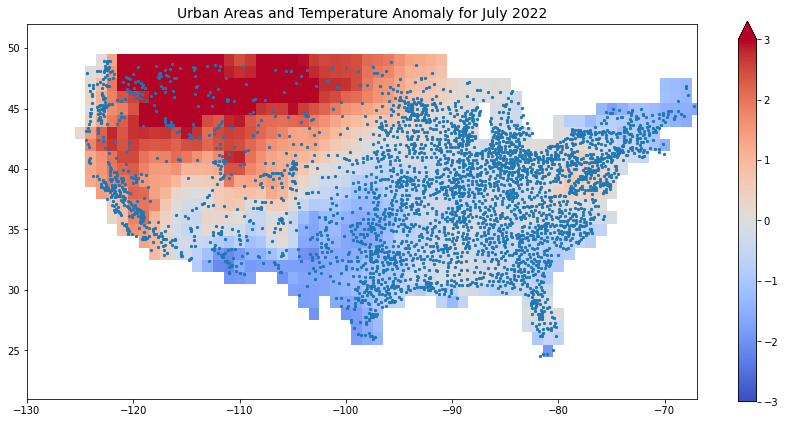

In [143]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

tanomaly.plot.imshow(ax=ax,
    vmin=-3, vmax=3, add_labels=False, cmap='coolwarm')
gdf.plot(ax=ax, markersize=5)
ax.set_xlim([tanomaly.x.min(), tanomaly.x.max()])
ax.set_ylim([tanomaly.y.min(), tanomaly.y.max()])
ax.set_title('Urban Areas and Temperature Anomaly for July 2022', fontsize = 14)

plt.show()

## Sampling Raster Values

Now we will extract the value of the raster pixels at each urban area point. Xarray's `sel()` method allows you to specify coordinates at multiple dimentions to extract the array value.

We have our coordinates in a GeoDataFrame, we can use Panda's `to_xarray()` method to convert the X and Y coordinates to a DataArray. When we use this to select the pixels from the raster array, the resulting DataArray being reindexed by the GeoDataFrame's index.This will allow us to merge the results easily to the original GeoDataFrame.

In [144]:
x_coords = gdf.geometry.x.to_xarray()
y_coords = gdf.geometry.y.to_xarray()

Now we sample the values at these coordinates. Note that since the raster data pixels will not be indexed at the exact X and Y coordinates, we use `method=nearest` to pick the closest pixel.

In [145]:
sampled = tanomaly.sel(x=x_coords, y=y_coords, method='nearest')

To convert the resulting DataArray to Pandas, we use `to_series()` method.

In [146]:
gdf['tanomaly'] = sampled.to_series()
gdf

,GEOID,NAME,UATYPE,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,geometry,tanomaly
0,37,"Abbeville, LA Urban Cluster",C,29189598,298416,11.270,0.115,29.967156,-92.095966,POINT (-92.09597 29.96716),-0.272462
1,64,"Abbeville, SC Urban Cluster",C,11271136,19786,4.352,0.008,34.179273,-82.379776,POINT (-82.37978 34.17927),-0.704404
2,91,"Abbotsford, WI Urban Cluster",C,5426584,13221,2.095,0.005,44.948612,-90.315875,POINT (-90.31588 44.94861),0.130515
3,118,"Aberdeen, MS Urban Cluster",C,7416338,52820,2.863,0.020,33.824742,-88.554591,POINT (-88.55459 33.82474),0.018811
4,145,"Aberdeen, SD Urban Cluster",C,33032902,120864,12.754,0.047,45.463186,-98.471033,POINT (-98.47103 45.46319),1.311932
...,...,...,...,...,...,...,...,...,...,...,...
3596,98101,"Zapata--Medina, TX Urban Cluster",C,13451264,0,5.194,0.000,26.889081,-99.266192,POINT (-99.26619 26.88908),-1.866690
3597,98182,"Zephyrhills, FL Urbanized Area",U,112593840,1615599,43.473,0.624,28.285373,-82.198969,POINT (-82.19897 28.28537),-0.064647
3598,98209,"Zimmerman, MN Urban Cluster",C,24456008,2495147,9.443,0.963,45.455850,-93.606705,POINT (-93.60671 45.45585),0.607703
3599,98236,"Zumbrota, MN Urban Cluster",C,4829469,0,1.865,0.000,44.292793,-92.670931,POINT (-92.67093 44.29279),0.007632


Now that we have the anomaly at each point location, let's sort and find out the Top10 locations with highest anomaly.

In [147]:
sorted_gdf = gdf.sort_values(by=['tanomaly'], ascending=False)
top10 = sorted_gdf.iloc[:10].reset_index()
top10

,index,GEOID,NAME,UATYPE,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,geometry,tanomaly
0,2440,66093,"Osburn, ID Urban Cluster",C,3219676,14,1.243,0.000,47.492018,-115.972889,POINT (-115.97289 47.49202),5.214408
1,1634,44263,"Kellogg, ID Urban Cluster",C,5118881,76405,1.976,0.030,47.537912,-116.132364,POINT (-116.13236 47.53791),4.543093
2,1839,49609,"Libby, MT Urban Cluster",C,7444836,88005,2.874,0.034,48.393944,-115.562191,POINT (-115.56219 48.39394),4.543093
3,336,9001,"Bonners Ferry, ID Urban Cluster",C,5303488,64130,2.048,0.025,48.690567,-116.320015,POINT (-116.32001 48.69057),4.487802
4,2431,65890,"Orofino, ID Urban Cluster",C,5518043,666938,2.131,0.258,46.493380,-116.286074,POINT (-116.28607 46.49338),4.411723
5,1270,34435,"Grangeville, ID Urban Cluster",C,3987396,429,1.540,0.000,45.926204,-116.123467,POINT (-116.12347 45.92620),4.411723
6,1707,46207,"La Grande, OR Urban Cluster",C,15679635,0,6.054,0.000,45.329383,-118.078699,POINT (-118.07870 45.32938),4.300000
7,172,4654,"Baker City, OR Urban Cluster",C,13005431,178981,5.021,0.069,44.783476,-117.828770,POINT (-117.82877 44.78348),4.300000
8,2700,73423,"Rathdrum, ID Urban Cluster",C,6729259,0,2.598,0.000,47.804999,-116.890251,POINT (-116.89025 47.80500),4.138633
9,835,22852,"Deer Park, WA Urban Cluster",C,4986176,0,1.925,0.000,47.955864,-117.468616,POINT (-117.46862 47.95586),4.138633


Let's plot them on a map.

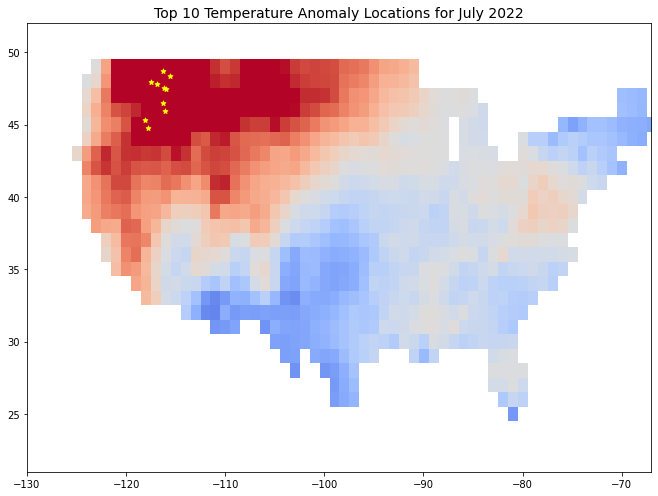

In [159]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

tanomaly.plot.imshow(ax=ax,
    vmin=-3, vmax=3, add_labels=False, cmap='coolwarm', add_colorbar=False)
top10.plot(ax=ax, markersize=25, color='yellow', marker='*')
ax.set_xlim([tanomaly.x.min(), tanomaly.x.max()])
ax.set_ylim([tanomaly.y.min(), tanomaly.y.max()])
ax.set_title('Top 10 Temperature Anomaly Locations for July 2022', fontsize = 14)

plt.tight_layout()
plt.show()

Finally, we save the sampled result to disk as `.gpkg`.

In [155]:
output_filename = 'tanomaly.gpkg'
output_path = os.path.join(output_folder, output_filename)

gdf.to_file(driver='GPKG', filename=output_path)